SQL exam submission

## <font color=#9467bd>Table of contents</font>
- Theory questions

- AdventureWorks2022
    - Introduction
    - Sales Analysis
    - Production Analysis
    - HR Analysis
    - Conclusion

- Självvärdering

***
# <font color=#9467bd>Teoretiska Frågor</font>
1. Beskriv kort hur en relationsdatabas fungerar.
2. Vad menas med “CRUD”-flödet?
3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?
4. Beskriv kort vad indexering i SQL innebär.
5. Beskriv kort vad en vy i SQL är.
6. Beskriv kort vad en lagrad procedur i SQL är.

***
# <font color= #9467bd>AdventureWorks2022 Analysis</font>

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

In [766]:
sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set_palette("plasma")

In [4]:
engine = create_engine("mssql+pyodbc://localhost/AdventureWorks2022?trusted_connection=yes&Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server")
connection = engine.connect()

***
## <font color= #1f77b4>Introduction</font>

- Adventure Works is a fictional bicycle company, founded in 2006. The company is based in Washington state, USA and has 290 employees. The company produces bicycle parts and sells them to vendors and individual customers. The current CEO is Ken J Sánchez who has been in this position since 2009.
- The database contains data covering sales, production, HR.
- The goal of this report is to explore and visualise key trends and insights.


***
## <font color= #1f77b4>Sales Analysis</font>

1. Total sales over time
2. Sales by season
3. Sales by country
4. Sales representatives
5. Sales by customer type

### Total sales over time:

<div class="alert alert-block alert-info">Sales records cover the years 2011-2014 only.</div>

In [5]:
sales_by_year = pd.read_sql(sql="""
      SELECT 
		YEAR(OrderDate) AS OrderYear, 
		CAST(SUM(TotalDue) AS INT) AS TotalSales 
	FROM Sales.SalesOrderHeader 
	GROUP BY YEAR(OrderDate) 
	ORDER BY YEAR(OrderDate)
;                                             
""", con=connection)
sales_by_year

,OrderYear,TotalSales
0,2011,14155700
1,2012,37675700
2,2013,48965888
3,2014,22419498


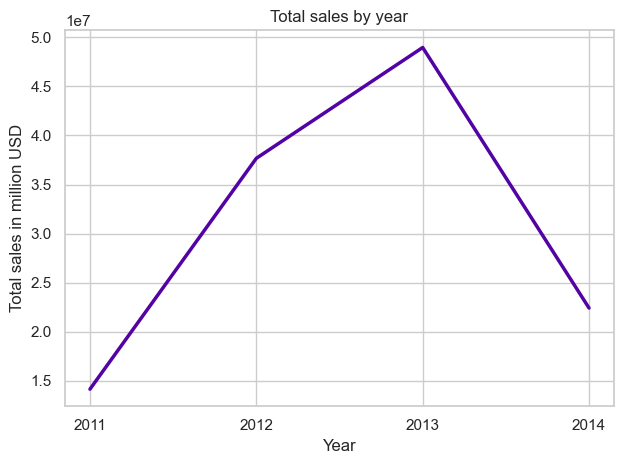

In [6]:
g = sns.lineplot(data=sales_by_year, x="OrderYear", y="TotalSales", linewidth=2.5)
g.set_xticks(range(2011, 2015))
g.set_title("Total sales by year")
g.set_ylabel("Total sales in million USD")
g.set_xlabel("Year")
plt.tight_layout()
plt.show()

#### A 3-month moving average of total sales:

A better way to display fluctuations in sales amounts is a three month moving average, taking the average of the current month and the two months before it, so that the results are not affected by a spike in any one month's sales total.

In [7]:
threemonth_avg_sales = pd.read_sql(sql="""
WITH SalesMonth AS
	(SELECT	
		FORMAT(OrderDate, 'yyyy-MM') AS SalesMonth,
		TotalDue
	FROM Sales.SalesOrderHeader
	)
, TotalSales AS
	(SELECT	
		SalesMonth,
		SUM(TotalDue) AS TotalSales
	FROM SalesMonth
	GROUP BY SalesMonth	
	)
SELECT
	SalesMonth AS 'Sales Month',
	CAST(TotalSales AS INT) AS 'Total Sales',
	CAST(AVG(TotalSales) OVER (ORDER BY SalesMonth ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS INT) AS '3 month average'
FROM TotalSales
;
""", con=connection)
threemonth_avg_sales.head()

,Sales Month,Total Sales,3 month average
0,2011-05,567021,567021
1,2011-06,507096,537059
2,2011-07,2292183,1122100
3,2011-08,2800576,1866619
4,2011-09,554792,1882517


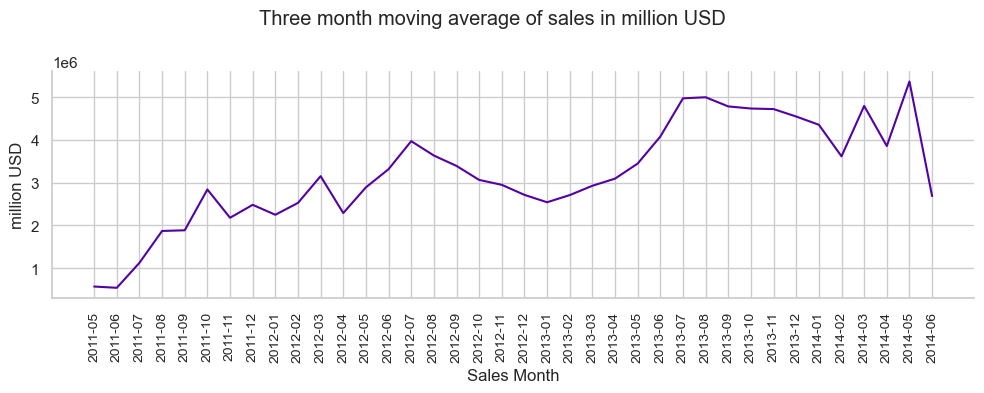

In [8]:
g = sns.relplot(data=threemonth_avg_sales, x="Sales Month", y="3 month average", kind="line", height=4, aspect=2.5)

g.set_xticklabels(rotation=90, size='small')
g.set_ylabels("million USD")
g.figure.suptitle("Three month moving average of sales in million USD")
plt.tight_layout()
plt.show()

### Average sales by season:

Are sales better at any specific time of the year?
    
Looking at the plot of total sales by season, it does not appear that seasonality affects the total amount of sales. Winter, visually, has the least total amount of sales but the box plot values overlap.

Analysis of Variance (ANOVA) test confirms that the difference in sales between seasons is not statistically significant (F-statistic = 0.12, p-value = 0.945).

In [9]:
sales_by_month = pd.read_sql(sql="""
WITH Season AS
(SELECT	
	TotalDue,
	OrderDate,
	FORMAT(OrderDate, 'yyyy') AS SalesYear,
	FORMAT(OrderDate, 'MM') AS SalesMonth,
	CASE 
		WHEN FORMAT(OrderDate, 'MM') IN (01, 02, 12) THEN 'Winter'
		WHEN FORMAT(OrderDate, 'MM') IN (03, 04, 05) THEN 'Spring'
		WHEN FORMAT(OrderDate, 'MM') IN (06, 07, 08) THEN 'Summer'
		WHEN FORMAT(OrderDate, 'MM') IN (09, 10, 11) THEN 'Fall'
	END AS Season
		
	FROM Sales.SalesOrderHeader
	)
, SalesMonth AS
(SELECT 
	OrderDate,
	CONCAT_WS('-', SalesYear, SalesMonth) AS SalesMonth
FROM Season
)
SELECT	
	SUM(a.TotalDue) AS TotalSales,
	b.SalesMonth,
	a.Season
FROM Season AS a INNER JOIN SalesMonth AS b
	ON a.OrderDate = b.OrderDate
GROUP BY b.SalesMonth, a.Season
ORDER BY b.SalesMonth ASC
;
""" , con=connection)
sales_by_month.head()

,TotalSales,SalesMonth,Season
0,2.438190e+07,2011-05,Spring
1,2.811137e+06,2011-06,Summer
2,1.434020e+08,2011-07,Summer
3,1.306637e+08,2011-08,Summer
4,3.872880e+06,2011-09,Fall


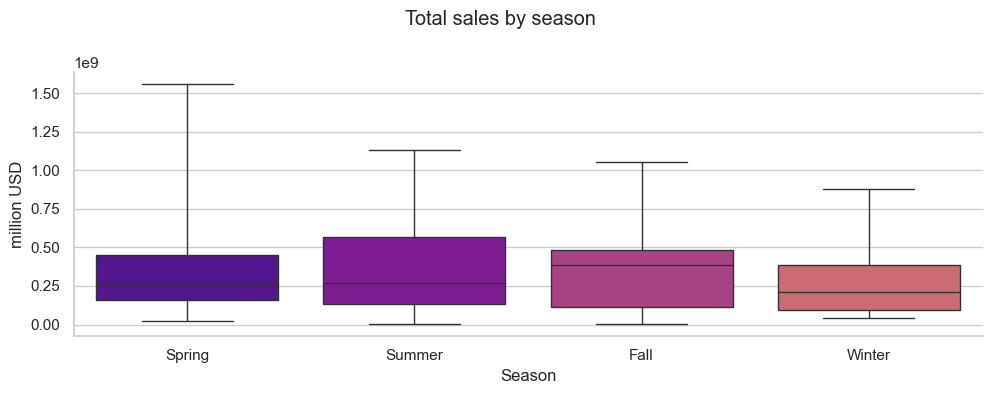

In [10]:
g = sns.catplot(data=sales_by_month, x="Season", y="TotalSales", kind="box", hue="Season", whis=(0,100), height=4, aspect=2.5)
g.figure.suptitle("Total sales by season")
g.set(ylabel="million USD")
plt.tight_layout()
plt.show()

Analysis of Variance (ANOVA) test for sales by season:

In [11]:
groups = sales_by_month.groupby('Season')['TotalSales'].apply(list)
f_statistic, p_value = stats.f_oneway(*groups)
print(f"F-Statistic: {f_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

F-Statistic: 0.12
P-value: 0.945


### Sales by country


Sales are divided into online sales directly to customers and store sales in six sales territories assigned to sales representatives.

Outside of the USA, Australia is the country with the highest online sales.

In [803]:
online_sales = pd.read_sql(sql="""
WITH CountryName AS
(SELECT 
	TerritoryID,
	CASE
  		WHEN CountryRegionCode = 'US' THEN 'USA'
		WHEN CountryRegionCode = 'CA' THEN 'Canada'
		WHEN CountryRegionCode = 'AU' THEN 'Australia'
		WHEN CountryRegionCode = 'GB' THEN 'United Kingdom'
   		WHEN CountryRegionCode = 'DE' THEN 'Germany'
		WHEN CountryRegionCode = 'FR' THEN 'France'
		ELSE NULL
	END AS CountryName		
FROM Sales.SalesTerritory
)
, Total_sales AS
(SELECT	
	TerritoryID,
	CAST(TotalDue AS DECIMAL(9, 2)) AS Total_sales
FROM Sales.SalesOrderHeader
WHERE OnlineOrderFlag = 1
)
SELECT	
	c.CountryName,
	SUM(s.Total_sales) AS Total_sales

FROM CountryName AS c JOIN Total_sales AS s
	ON c.TerritoryID = s.TerritoryID
GROUP BY CountryName
ORDER BY Total_sales DESC
;
""", con=connection)
online_sales

,CountryName,Total_sales
0,USA,10375715.63
1,Australia,10012404.31
2,United Kingdom,3747841.56
3,Germany,3198215.03
4,France,2921639.36
5,Canada,2185517.93


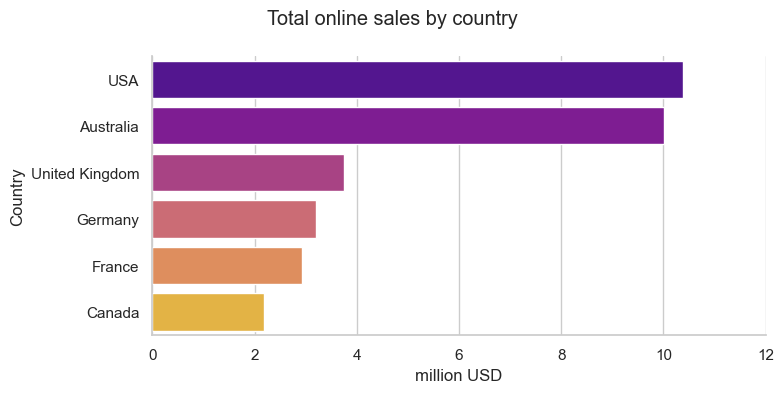

In [805]:
g = sns.catplot(data=online_sales, x="Total_sales", y="CountryName", hue="CountryName", kind="bar", height=4, aspect=2)
g.figure.suptitle("Total online sales by country")
g.set(xlabel="million USD")
g.set(ylabel="Country")

ticks = g.axes[0][0].get_xticks()
xlabels = [f'{x/10**6:,.0f}'.format(x) for x in ticks]
g.set_xticklabels(xlabels)

plt.tight_layout()
plt.show()

In [806]:
store_sales = pd.read_sql(sql="""
WITH CountryName AS
(SELECT 
	TerritoryID,
	CASE
  		WHEN CountryRegionCode = 'US' THEN 'USA'
		WHEN CountryRegionCode = 'CA' THEN 'Canada'
		WHEN CountryRegionCode = 'AU' THEN 'Australia'
		WHEN CountryRegionCode = 'GB' THEN 'United Kingdom'
   		WHEN CountryRegionCode = 'DE' THEN 'Germany'
		WHEN CountryRegionCode = 'FR' THEN 'France'
		ELSE NULL
	END AS CountryName	
FROM Sales.SalesTerritory
)
, Total_sales AS
(SELECT	
	TerritoryID,
	CAST(TotalDue AS DECIMAL(9, 2)) AS Total_sales
FROM Sales.SalesOrderHeader
WHERE OnlineOrderFlag = 0
)
SELECT	
	c.CountryName,
	SUM(s.Total_sales) AS Total_sales

FROM CountryName AS c JOIN Total_sales AS s
	ON c.TerritoryID = s.TerritoryID
GROUP BY CountryName
ORDER BY Total_sales DESC
;
""", con=connection)
store_sales

,CountryName,Total_sales
0,USA,60454145.57
1,Canada,16213410.48
2,France,5198109.67
3,United Kingdom,4826206.67
4,Germany,2281604.43
5,Australia,1801970.29


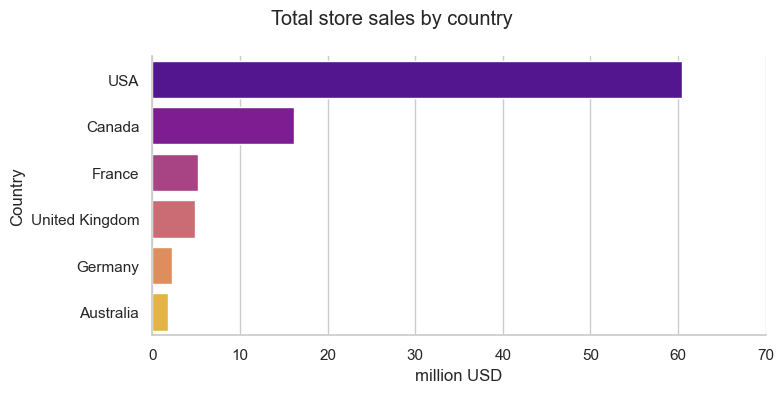

In [808]:
g = sns.catplot(data=store_sales, x="Total_sales", y="CountryName", hue="CountryName", kind="bar", height=4, aspect=2)
g.figure.suptitle("Total store sales by country")
g.set(xlabel="million USD")
g.set(ylabel="Country")

ticks = g.axes[0][0].get_xticks()
xlabels = [f'{x/10**6:,.0f}'.format(x) for x in ticks]
g.set_xticklabels(xlabels)

plt.tight_layout()
plt.show()

### Sales representatives, their territories and number of stores.

In [813]:
sales_reps = pd.read_sql(sql="""
SELECT	
	CONCAT_WS(' ', p.FirstName, p.LastName) AS EmployeeName,
	e.JobTitle AS JobTitle,
	t.Name AS Territory,
	t.CountryRegionCode AS Country,
 	COUNT(r.Name) AS Stores,	
	CAST(s.SalesYTD AS DECIMAL(9, 2)) AS SalesYTD,
	CAST(s.SalesLastYear AS DECIMAL(9,2)) AS SalesLastYear,
	CAST(s.SalesYTD + s.SalesLastYear AS DECIMAL(9,2)) AS SalesTotal	
FROM Sales.SalesPerson AS s
	LEFT JOIN HumanResources.Employee AS e
	ON s.BusinessEntityID = e.BusinessEntityID
	LEFT JOIN Person.Person AS p
	ON s.BusinessEntityID = p.BusinessEntityID
	LEFT JOIN Sales.SalesTerritory AS t
	ON s.TerritoryID = t.TerritoryID
	LEFT JOIN Sales.Store AS r
	ON s.BusinessEntityID = r.SalesPersonID
GROUP BY t.Name, t.CountryRegionCode, e.JobTitle, p.FirstName, p.LastName, s.SalesYTD, s.SalesLastYear
ORDER BY Country, Territory, SalesTotal DESC
;
""", con=connection)
sales_reps

,EmployeeName,JobTitle,Territory,Country,Stores,SalesYTD,SalesLastYear,SalesTotal
0,Stephen Jiang,North American Sales Manager,None,None,0,559697.56,0.00,559697.56
1,Amy Alberts,European Sales Manager,None,None,0,519905.93,0.00,519905.93
2,Syed Abbas,Pacific Sales Manager,None,None,0,172524.45,0.00,172524.45
3,Lynn Tsoflias,Sales Representative,Australia,AU,40,1421810.92,2278548.98,3700359.90
4,José Saraiva,Sales Representative,Canada,CA,74,2604540.72,2038234.65,4642775.37
5,Garrett Vargas,Sales Representative,Canada,CA,40,1453719.47,1620276.90,3073996.36
6,Rachel Valdez,Sales Representative,Germany,DE,40,1827066.71,1307949.79,3135016.50
7,Ranjit Varkey Chudukatil,Sales Representative,France,FR,40,3121616.32,2396539.76,5518156.08
8,Jae Pak,Sales Representative,United Kingdom,GB,40,4116871.23,1635823.40,5752694.62
9,Jillian Carson,Sales Representative,Central,US,76,3189418.37,1997186.20,5186604.57


### Sales by customer type

In [16]:
order_values = pd.read_sql(sql="""
SELECT
	CustomerID,
	TotalDue,
	OnlineOrderFlag
FROM Sales.SalesOrderHeader	
;
""", con=connection)
order_values.head()


,CustomerID,TotalDue,OnlineOrderFlag
0,29825,23153.2339,False
1,29672,1457.3288,False
2,29734,36865.8012,False
3,29994,32474.9324,False
4,29565,472.3108,False


In [17]:
online = order_values[order_values["OnlineOrderFlag"] == 1]
store = order_values[order_values["OnlineOrderFlag"] == 0]

ttest_ind = stats.ttest_ind(online["TotalDue"], store["TotalDue"], equal_var=False)
print(f"Statistic: {ttest_ind.statistic}")
print(f"P-value: {ttest_ind.pvalue}")
print(f"Mean online order value: {online['TotalDue'].mean()}")
print(f"Mean store order value: {store['TotalDue'].mean()}")
print(f"Mean difference: {online['TotalDue'].mean() - store['TotalDue'].mean()}")


Statistic: -48.516151278508694
P-value: 0.0
Mean online order value: 1172.9035439748363
Mean store order value: 23850.616656095634
Mean difference: -22677.713112120797


Using two independent sample t-test to determine if there is a significant difference between the total order amount of online customers and store customers:
The results show that there is a statistically significant difference between store orders and online orders, with the mean online order value: 1172.90 USD and mean store order value: 23850.62 USD.

In [77]:
order_count = pd.read_sql(sql="""
                            SELECT
	CustomerID,
    OnlineOrderFlag,
	COUNT(*) AS Order_count,
	SUM(TotalDue) AS Total_amount
FROM Sales.SalesOrderHeader
GROUP BY CustomerID, OnlineOrderFlag
ORDER BY Order_count DESC
;
""", con=connection)
order_count.head()

,CustomerID,OnlineOrderFlag,Order_count,Total_amount
0,11176,True,28,1458.6118
1,11091,True,28,1314.2103
2,11300,True,27,1658.0753
3,11331,True,27,1468.8883
4,11711,True,27,1219.6778


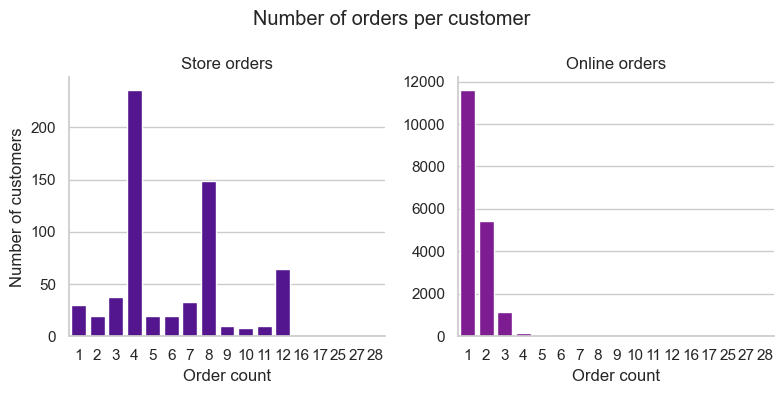

In [64]:
g = sns.catplot(data=order_count, x="Order_count", col="OnlineOrderFlag", hue="OnlineOrderFlag", 
                kind="count", sharey=False, legend=False, height=4, aspect=1)
g.set_axis_labels("Order count", "Number of customers")
custom_colnames = ["Store orders", "Online orders"]
for i, ax in enumerate(g.axes[0]):
    ax.set_title(custom_colnames[i])
plt.suptitle("Number of orders per customer")
plt.tight_layout()
plt.show()


The above chart shows that store customers are more likely to place repeated orders, whereas most online customers shop once or twice.

## <font color= #1f77b4>Production Analysis</font>

1. Product categories and subcategories
2. Product cost and profitability


Create a scatter plot with product price on the x-axis and sales quantity on the y-axis to visually inspect the relationship.

Calculate the correlation between product price (ListPrice in Production.Product) and sales quantity (OrderQty in Sales.SalesOrderDetail). Is there a relationship between price and how much of a product is sold?

### Product categories and subcategories

A total of 266 different products have been sold in 35 subcategories and 4 categories: Bikes, Components, Clothing, and Accessories.

In [ ]:
sales_all = pd.read_sql(sql="""
WITH Total_sold AS
(SELECT
	ProductID,
	SUM(OrderQty) AS Total_sold	
FROM
	Sales.SalesOrderDetail
GROUP BY ProductID
)
, Total_amount AS
(SELECT
	s.ProductID,
	SUM(OrderQty * LineTotal) AS Total_amount,
	SUM(OrderQty * StandardCost) AS Total_cost
FROM Sales.SalesOrderDetail AS s 
	INNER JOIN Production.Product AS p
	ON s.ProductID = p.ProductID
GROUP BY s.ProductID
)
SELECT
	t.ProductID,
	t.Total_sold,
	p.Name AS Product,
	s.Name AS Subcategory,
	c.Name AS Category,
	a.Total_amount AS Revenue,
	a.Total_cost AS Cost,
	(a.Total_amount - a.Total_cost) AS Profit
FROM
	Total_sold AS t
	INNER JOIN Production.Product AS p
	ON t.ProductID = p.ProductID
	INNER JOIN Production.ProductSubcategory AS s
	ON p.ProductSubcategoryID = s.ProductSubcategoryID
	INNER JOIN Production.ProductCategory AS c
	ON s.ProductCategoryID = c.ProductCategoryID
	INNER JOIN Total_amount AS a
	ON t.ProductID = a.ProductID
ORDER BY Profit DESC
;
""", con=connection)
sales_all.head()

,ProductID,Total_sold,Product,Subcategory,Category,Revenue,Cost,Profit
0,782,2977,"Mountain-200 Black, 38",Mountain Bikes,Bikes,1.769810e+07,3.727148e+06,1.397095e+07
1,783,2664,"Mountain-200 Black, 42",Mountain Bikes,Bikes,1.518469e+07,3.335278e+06,1.184941e+07
2,779,2394,"Mountain-200 Silver, 38",Mountain Bikes,Bikes,1.367194e+07,3.029893e+06,1.064204e+07
3,780,2234,"Mountain-200 Silver, 42",Mountain Bikes,Bikes,1.232848e+07,2.827394e+06,9.501082e+06
4,781,2216,"Mountain-200 Silver, 46",Mountain Bikes,Bikes,1.185134e+07,2.804613e+06,9.046723e+06


In [729]:
product_count = sales_all.select_dtypes(exclude='number').nunique()
product_count

Product        266
Subcategory     35
Category         4
dtype: int64

In [ ]:
money_metrics = sales_all[['Category', 'Subcategory', 'Revenue', 'Cost', 'Profit']]
money_metrics.sort_values(by='Profit', ascending=False)
money_melt = money_metrics.melt(id_vars=['Category', 'Subcategory'], var_name='Metric', value_name='Amount')
money_melt.loc[:, 'Amount'] = money_melt['Amount'] / 1e6

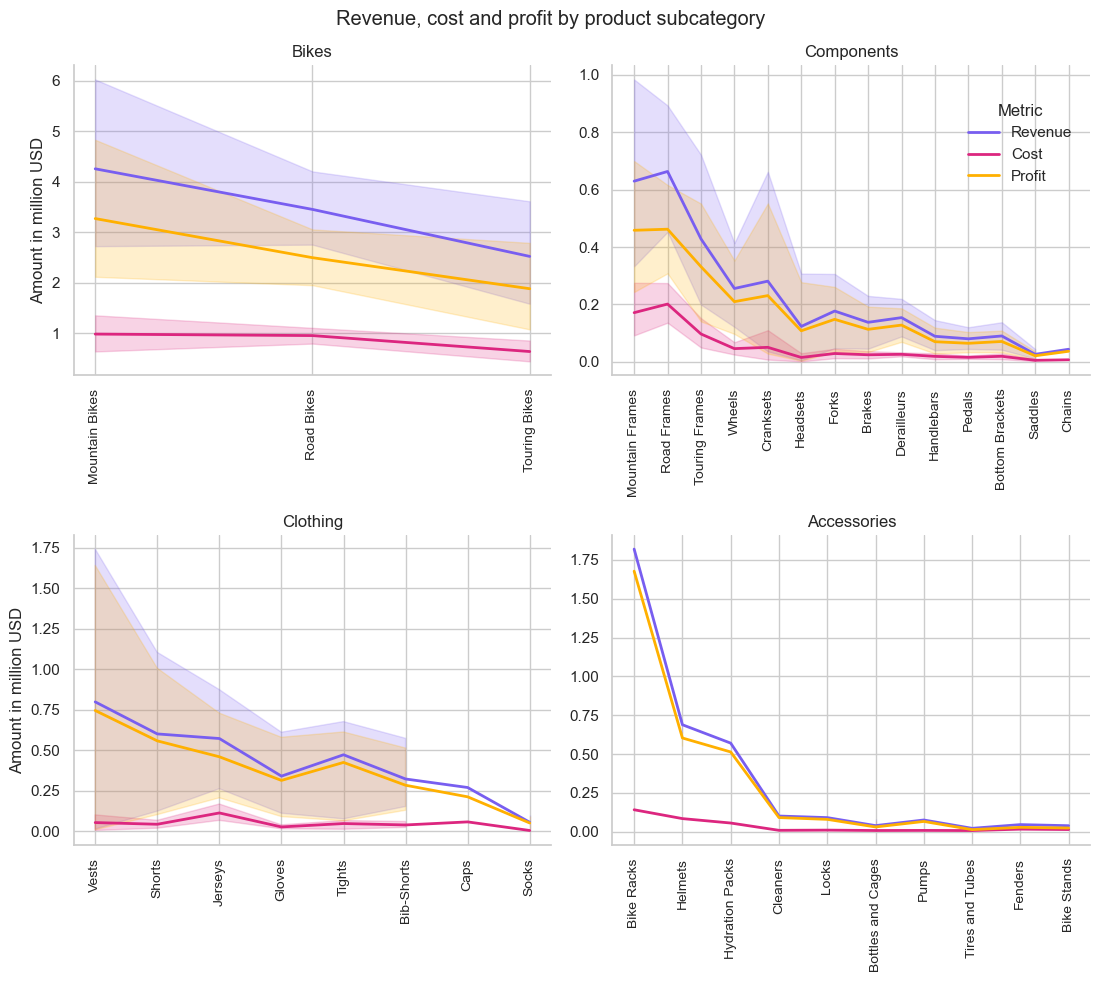

In [816]:
colors = sns.color_palette(['#785EF0', '#DC267F', '#FFB000'])

g = sns.relplot(data=money_melt, y="Amount", x="Subcategory", col="Category", col_wrap=2, kind="line", hue="Metric", 
                facet_kws={'sharey': False, 'sharex': False}, col_order=['Bikes', 'Components', 'Clothing', 'Accessories'], 
                palette=colors, linewidth=2)  
g.set_xticklabels(rotation=90, size='small')
g.set_titles("{col_name}")
g.set_ylabels("Amount in million USD")
g.set_xlabels("")

g.figure.suptitle("Revenue, cost and profit by product subcategory")
sns.move_legend(g, "upper right", bbox_to_anchor=(0.98, 0.9))
plt.tight_layout()

plt.show()                

### Top 10 most sold products

In [739]:
sold_sorted = sales_all.sort_values(by='Total_sold', ascending=False)
most_sold = sold_sorted.head(10)
most_sold

,ProductID,Total_sold,Product,Subcategory,Category,Revenue,Cost,Profit
149,712,8311,AWC Logo Cap,Caps,Clothing,2.698792e+05,57531.2353,2.123480e+05
198,870,6815,Water Bottle - 30 oz.,Bottles and Cages,Accessories,8.483109e+04,12718.8345,7.211226e+04
98,711,6743,"Sport-100 Helmet, Blue",Helmets,Accessories,7.285087e+05,88240.9209,6.402677e+05
69,715,6592,"Long-Sleeve Logo Jersey, L",Jerseys,Clothing,1.418467e+06,253741.2416,1.164725e+06
99,708,6532,"Sport-100 Helmet, Black",Helmets,Accessories,7.054294e+05,85479.7116,6.199497e+05
108,707,6266,"Sport-100 Helmet, Red",Helmets,Accessories,6.328289e+05,81998.7558,5.508302e+05
52,864,4247,"Classic Vest, S",Vests,Clothing,1.742394e+06,100862.0030,1.641532e+06
248,873,3865,Patch Kit/8 Patches,Tires and Tubes,Accessories,1.239726e+04,3310.3725,9.086885e+03
77,884,3864,"Short-Sleeve Classic Jersey, XL",Jerseys,Clothing,1.105034e+06,160635.3672,9.443987e+05
115,714,3636,"Long-Sleeve Logo Jersey, M",Jerseys,Clothing,5.806192e+05,139958.0028,4.406612e+05


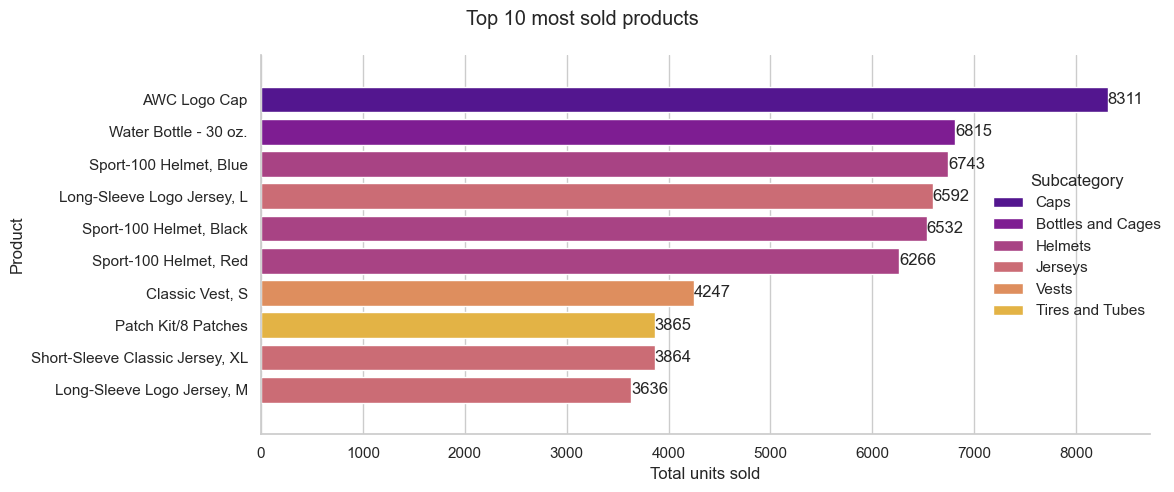

In [817]:
g = sns.catplot(data=most_sold, x="Total_sold", y="Product", kind="bar", hue="Subcategory", aspect=2)
g.set_axis_labels("Total units sold", "Product")
g.figure.suptitle("Top 10 most sold products")

for container in g.ax.containers:
    g.ax.bar_label(container, label_type='edge')
g.ax.margins(y=0.1)
plt.tight_layout()
plt.show()

In [763]:
most_sold_by_category = (
    sales_all.groupby('Category')[['Product', 'Category', 'Subcategory','Total_sold']] 
    .apply(lambda x: x.nlargest(5, 'Total_sold'))
    .reset_index(drop=True)
)

most_sold_by_category

,Product,Category,Subcategory,Total_sold
0,Water Bottle - 30 oz.,Accessories,Bottles and Cages,6815
1,"Sport-100 Helmet, Blue",Accessories,Helmets,6743
2,"Sport-100 Helmet, Black",Accessories,Helmets,6532
3,"Sport-100 Helmet, Red",Accessories,Helmets,6266
4,Patch Kit/8 Patches,Accessories,Tires and Tubes,3865
5,"Mountain-200 Black, 38",Bikes,Mountain Bikes,2977
6,"Mountain-200 Black, 42",Bikes,Mountain Bikes,2664
7,"Mountain-200 Silver, 38",Bikes,Mountain Bikes,2394
8,"Road-650 Black, 52",Bikes,Road Bikes,2270
9,"Road-650 Red, 44",Bikes,Road Bikes,2254


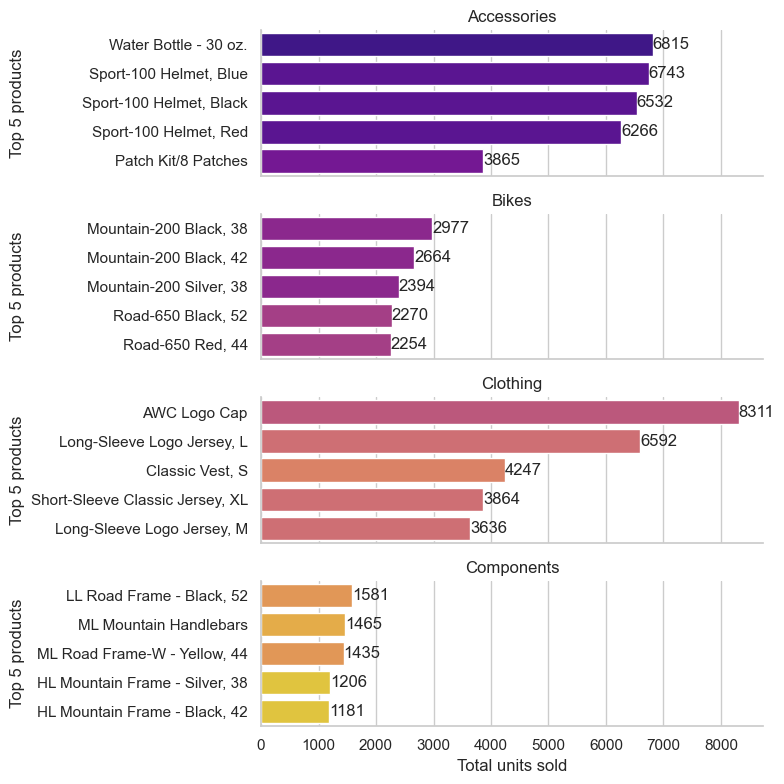

In [819]:
g = sns.catplot(data=most_sold_by_category, x="Total_sold", y="Product", kind="bar", 
                hue="Subcategory", row="Category", sharey=False, height=2, aspect=4, legend=False, palette='plasma')
g.set_axis_labels("Total units sold", "Top 5 products")
g.set_titles("{row_name}")
g.figure.align_ylabels(g.axes.flatten())
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')    
plt.tight_layout()
plt.show()

## <font color= #1f77b4>HR Analysis</font>

1. Employee distribution by department
2. Gender and age distribution
3. Salary distribution

Brief summary of findings:
- There are a total of 290 employees listed in the AdventureWorks2022 database. Employee gender distribution is 71% male and 29% female.
- The highest number of people are employed in the Production department, 179. On the other hand, only two people are listed in the Executive department.
- There is a large gap in pay rate between the Executive department and the rest of the departments.
- There is no statistically significant difference in pay rate by age, length of employment, or gender, implying that employees don't get pay raises with age or after a number of years employed.

In [20]:
total_employees = pd.read_sql(sql="""
SELECT	
	COUNT(*) AS total_employees
 FROM HumanResources.Employee
 ;
 """, con=connection)
total_employees

,total_employees
0,290


The following table represents the top level managers:

In [21]:
top_organization_level = pd.read_sql(sql="""
SELECT	
		CONCAT_WS(' ', b.FirstName, b.MiddleName, b.LastName) AS 'Employee Name',
		a.JobTitle AS 'Job Title',
		a.HireDate AS 'Hire Date'
		           
  FROM HumanResources.Employee AS a
	LEFT JOIN Person.Person AS b
	ON a.BusinessEntityID = b.BusinessEntityID
WHERE a.OrganizationLevel <= 1 OR a.OrganizationLevel IS NULL
ORDER BY a.OrganizationLevel ASC, a.HireDate ASC  
;
""", con=connection)
top_organization_level

,Employee Name,Job Title,Hire Date
0,Ken J Sánchez,Chief Executive Officer,2009-01-14
1,David M Bradley,Marketing Manager,2007-12-20
2,Terri Lee Duffy,Vice President of Engineering,2008-01-31
3,Jean E Trenary,Information Services Manager,2008-12-11
4,Laura F Norman,Chief Financial Officer,2009-01-31
5,James R Hamilton,Vice President of Production,2009-02-03
6,Brian S Welcker,Vice President of Sales,2011-02-15


In [333]:
employees_all = pd.read_sql(sql="""
WITH latest_department AS
(
SELECT	BusinessEntityID,
		DepartmentID,
		ROW_NUMBER() OVER (PARTITION BY BusinessEntityID ORDER BY StartDate DESC) AS row_nr
	FROM HumanResources.EmployeeDepartmentHistory
)
, latest_rate AS
(
SELECT	BusinessEntityID,
		Rate,
		ROW_NUMBER() OVER (PARTITION BY BusinessEntityID ORDER BY RateChangeDate DESC) AS row_nr
	FROM HumanResources.EmployeePayHistory
)
, Dates AS
(
SELECT
	BusinessEntityID,
	DATEDIFF(year, BirthDate, '2014-12-31') AS Age_in_2014,
	DATEDIFF(year, HireDate, '2014-12-31') AS Years_employed
FROM HumanResources.Employee
)
SELECT	
	e.BusinessEntityID AS EmployeeID,
	e.JobTitle AS JobTitle,
	lr.Rate AS PayRate,
	e.OrganizationLevel,
	e.Gender AS Gender,
	g.Age_in_2014,
	g.Years_employed,
	d.Name AS Department,
	d.GroupName AS GroupName,
	COUNT(e.BusinessEntityID) OVER(PARTITION BY d.DepartmentID) AS emp_dept,
	COUNT(e.BusinessEntityID) OVER(PARTITION BY d.GroupName) AS emp_group
  
FROM HumanResources.Employee AS e
	INNER JOIN Dates AS g
	ON e.BusinessEntityID = g.BusinessEntityID
	INNER JOIN latest_department AS ld
	ON e.BusinessEntityID = ld.BusinessEntityID AND ld.row_nr = 1
	INNER JOIN HumanResources.Department AS d
	ON ld.DepartmentID = d.DepartmentID
	INNER JOIN latest_rate AS lr
	ON e.BusinessEntityID = lr.BusinessEntityID AND lr.row_nr = 1
  ORDER BY e.BusinessEntityID ASC
;
""", con=connection)
employees_all.head(5)

,EmployeeID,JobTitle,PayRate,OrganizationLevel,Gender,Age_in_2014,Years_employed,Department,GroupName,emp_dept,emp_group
0,1,Chief Executive Officer,125.5000,NaN,M,45,5,Executive,Executive General and Administration,2,35
1,2,Vice President of Engineering,63.4615,1.0,F,43,6,Engineering,Research and Development,6,14
2,3,Engineering Manager,43.2692,2.0,M,40,7,Engineering,Research and Development,6,14
3,4,Senior Tool Designer,29.8462,3.0,M,40,7,Tool Design,Research and Development,4,14
4,5,Design Engineer,32.6923,3.0,F,62,6,Engineering,Research and Development,6,14


### Employee distribution by department:

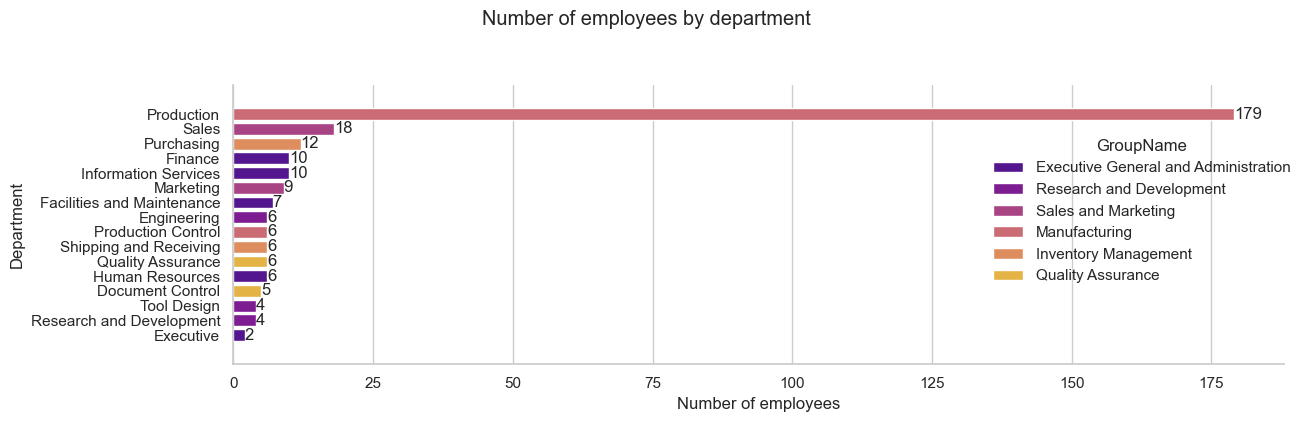

In [820]:
employees_by_department = employees_all['Department'].value_counts()

g = sns.catplot(data=employees_all, x="emp_dept", y="Department", hue="GroupName", 
                kind="bar", height=4, aspect=2.5, order=employees_by_department.index)
g.set(xlabel="Number of employees")
g.figure.suptitle("Number of employees by department", y=1.05)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    ax.margins(y=0.1)
plt.tight_layout()
plt.show()

### Employee distribution by group and department:

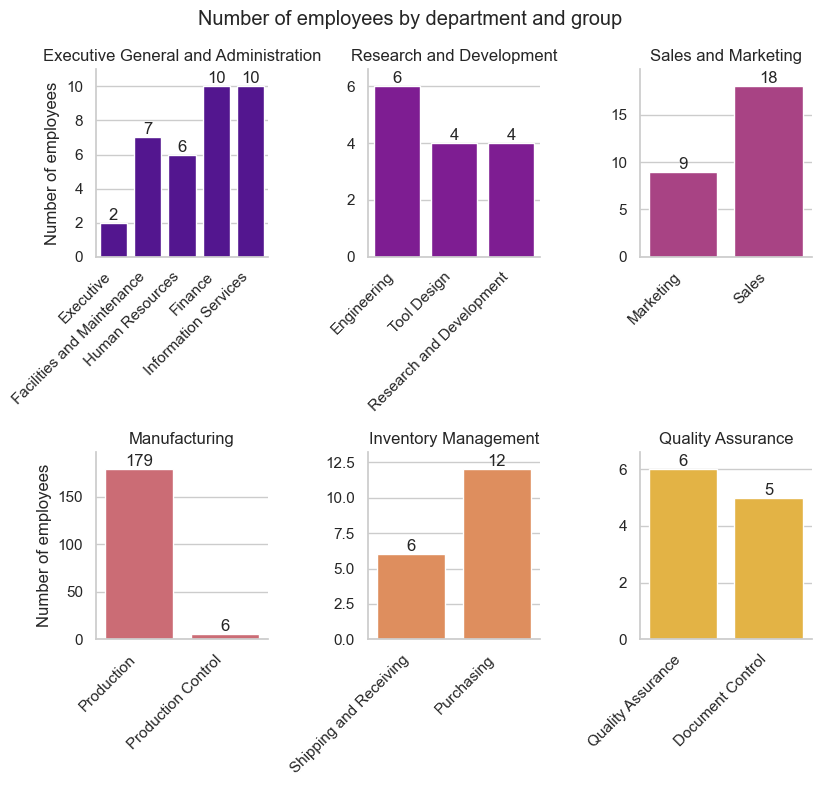

In [256]:
g = sns.catplot(data=employees_all, y="emp_dept", x="Department", 
                col="GroupName", col_wrap=3, kind="bar", hue="GroupName",
                sharex=False, sharey=False, legend=False, height=4, aspect=0.7)
g.set_xticklabels(rotation=45, ha='right')
g.set_xlabels("")
g.set_ylabels("Number of employees")
g.set_titles('{col_name}')
g.figure.suptitle("Number of employees by department and group")

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    ax.margins(y=0.1)

plt.tight_layout()
plt.show()

### Gender and age distribution of employees:

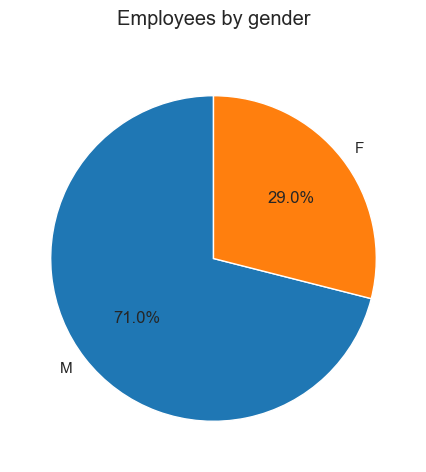

In [831]:
emp_gender = employees_all["Gender"].value_counts()
plt.pie(emp_gender, labels=emp_gender.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("tab10"))
plt.suptitle('Employees by gender')
plt.tight_layout()
plt.show()


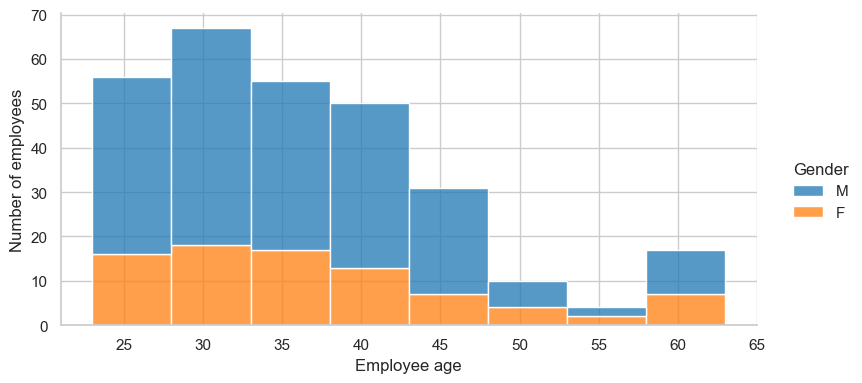

In [828]:
g = sns.displot(data=employees_all, x="Age_in_2014", hue="Gender", binwidth=5, height=4, aspect=2, 
                multiple="stack", palette="tab10")
g.set_axis_labels("Employee age", "Number of employees")
plt.show()

### Pay rate distribution:

Pay rate distribution by department and group shows that the majority of employees are low paid, with a higher outlier value for each department's manager. The following plots visualising the relationship between employees' age, years in employment, and pay rate, show that the pay rate is not related to either employee's age or the length of employment, but it is closely related to the employee's organisation level, with the pay rates highest at manager level. There is no statistically significant difference in pay rate by gender.

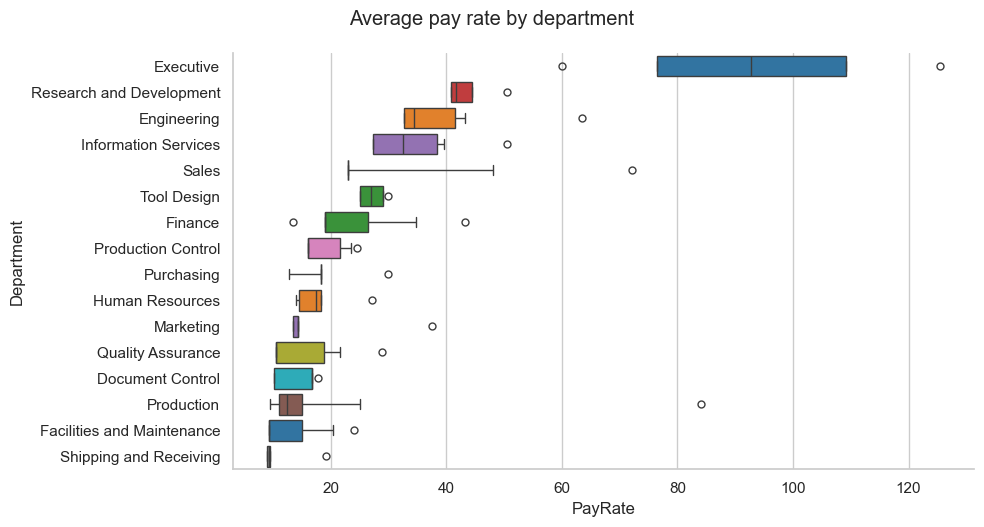

In [833]:
rate_sort = employees_all.groupby(by="Department")["PayRate"].mean().sort_values(ascending=False).index
g = sns.catplot(data=employees_all, y="Department", x="PayRate", kind="box", hue="Department", 
            order=rate_sort, whis=(5,95), aspect=2, palette="tab10")
g.figure.suptitle("Average pay rate by department", y=1.05)
plt.show()

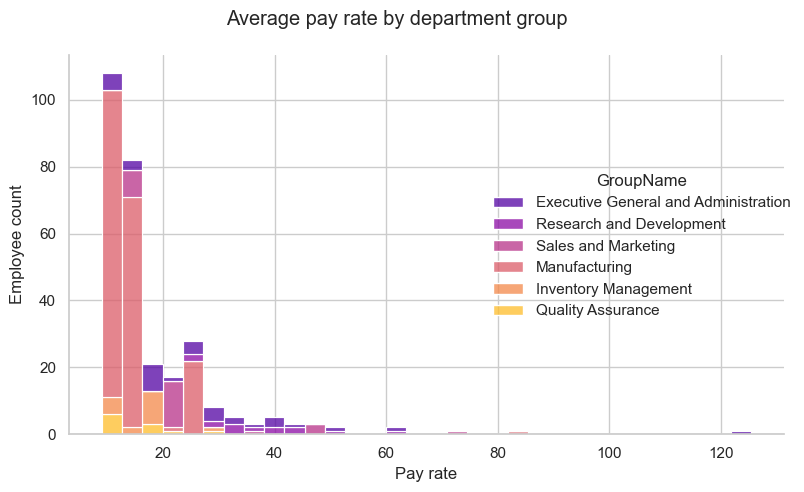

In [835]:
g = sns.displot(data=employees_all, x="PayRate", hue="GroupName", multiple="stack")
g.figure.suptitle("Average pay rate by department group")
g.set_axis_labels("Pay rate", "Employee count")
plt.tight_layout()
plt.show()

In [331]:
cols_corr = employees_all[['PayRate', 'Age_in_2014', 'Years_employed', 'OrganizationLevel']] 
correlation = cols_corr.corr()
corr_pay_age = correlation['PayRate']['Age_in_2014']
corr_pay_length = correlation['PayRate']['Years_employed']
corr_pay_level = correlation['PayRate']['OrganizationLevel']

print(f"Correlation between pay rate and employee age: {corr_pay_age:.2f}")
print(f"Correlation between pay pate and length of employment: {corr_pay_length:.2f}")
print(f"Correlation between pay rate and organization level: {corr_pay_level:.2f}")

Correlation between pay rate and employee age: 0.15
Correlation between pay pate and length of employment: -0.11
Correlation between pay rate and organization level: -0.75


Correlation coefficient value close to 0 indicates weak or no linear relationship. Value close to 1 indicates strong linear relationship.<br> 
The correlation coefficient of -0.75 for the pay rate and organization level indicates that there is a linear relationship between the two columns.

T-test for pay rate by gender shows that there is no statistically significant pay gap between male and female employees.

In [454]:
male_pay = employees_all[employees_all['Gender'] == 'M']['PayRate']
female_pay = employees_all[employees_all['Gender'] == 'F']['PayRate']

t_statistic, p_value = stats.ttest_ind(male_pay, female_pay)

print(f"T-Statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

T-Statistic: -0.92
P-value: 0.358


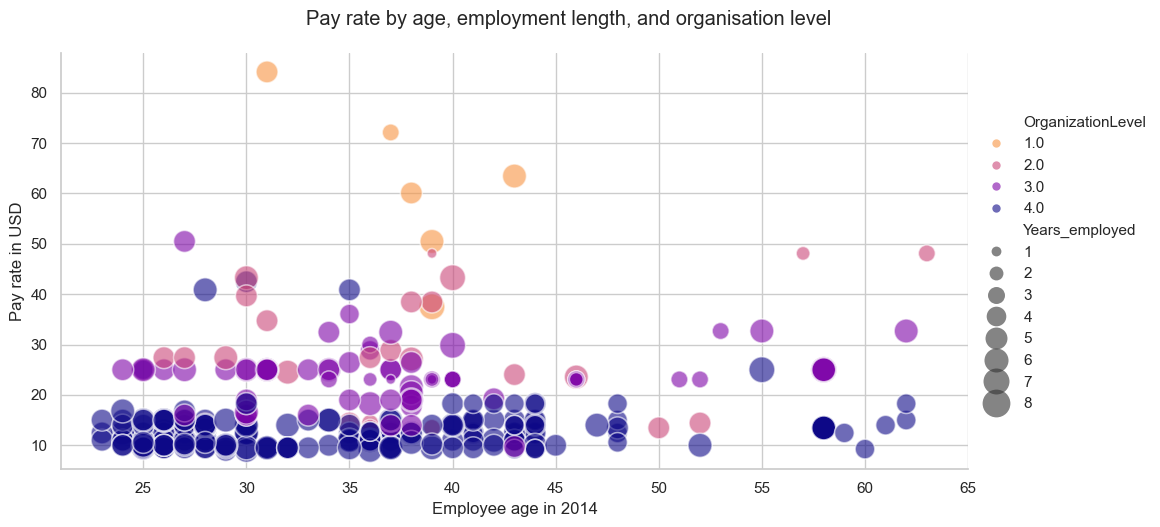

In [558]:
g = sns.relplot(data=employees_all, x="Age_in_2014", y="PayRate", kind="scatter", hue="OrganizationLevel", 
            size="Years_employed", sizes=([50, 100, 150, 200, 250, 300, 350, 400]), 
            palette="plasma_r", hue_norm=(0, 4), aspect=2, alpha=0.6)
g.set_axis_labels("Employee age in 2014", "Pay rate in USD") 
g.figure.suptitle("Pay rate by age, employment length, and organisation level", y=1.05)
plt.show()

## <font color= #1f77b4>Conclusion</font>

1. Key findings
2. Potential areas for further investigation or improvement

# <font color= #9467bd>Självvärdering</font>

1. Utmaningar du haft under arbetet samt hur du hanterat dem.
2. Vilket betyg du anser att du skall ha och varför.
3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.